In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transduction import examples, Precover, FSA, FST, EPSILON
from transduction.peekaboo_recursive import PeekabooState, Peekaboo
import transduction.peekaboo_recursive
from transduction.util import display_table

transduction.peekaboo_recursive.MAX_STEPS = 100

'abc'
'ab'
'a'
''


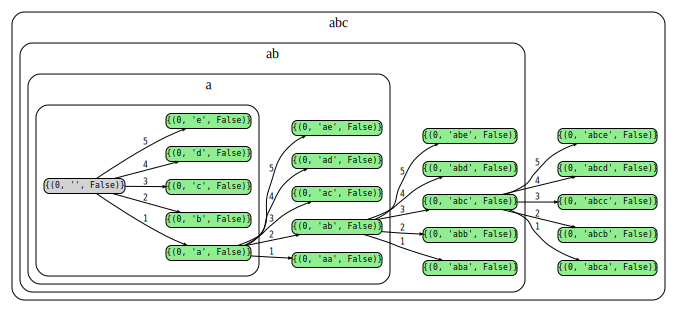

In [53]:
fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
Peekaboo(fst).graphviz('abc')

In [55]:
display_table([[Precover(fst, 'a'), Precover(fst, 'b'), Precover(fst, 'c')]])

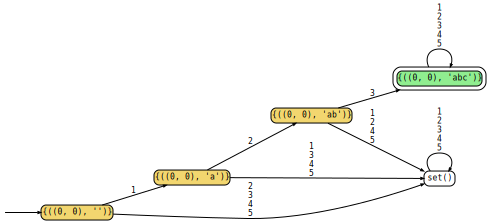

In [56]:
Precover(fst, 'abc')

In [57]:
Precover(fst, 'abc').show_decomposition(minimize=False, trim=False)

quotient,remainder


'1'
''


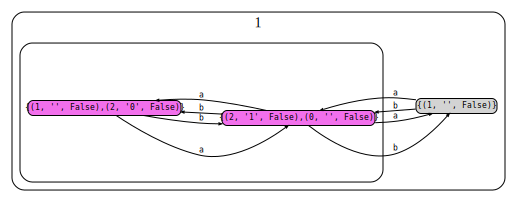

In [58]:
fst = examples.parity({'a', 'b'})
Peekaboo(fst).graphviz('1')

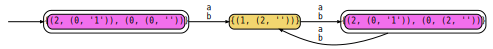

quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 0 <!-- start->0 --> start->0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 a b <!-- 1->0 --> 1->0 a b"


In [59]:
display(Precover(fst, '1'))
Precover(fst, '1').show_decomposition()

'cxx'
'cx'
'c'
''


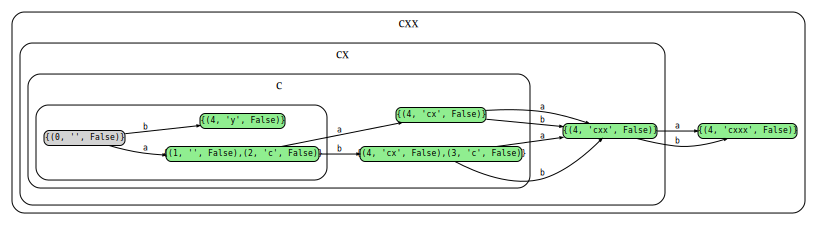

In [61]:
fst = examples.samuel_example()
Peekaboo(fst).graphviz('cxx')

'1'
''


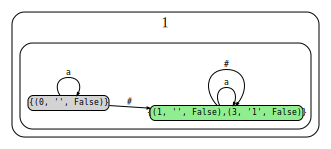

In [62]:
fst = examples.infinite_quotient()
Peekaboo(fst, max_steps=100).graphviz('1')

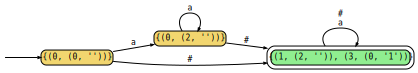

In [63]:
Precover(fst, '1')

'aabba'
'aabb'
'aab'
'aa'
'a'
''


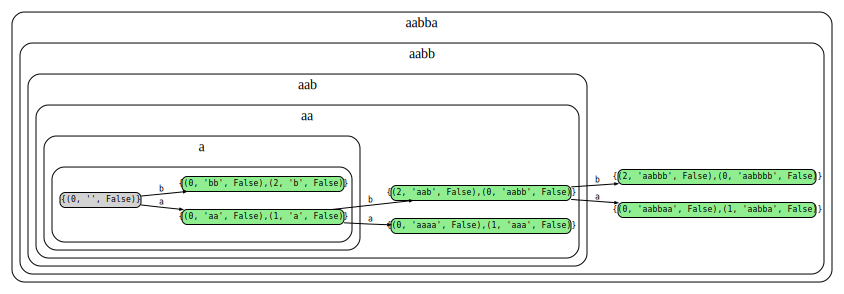

In [65]:
fst = examples.duplicate('ab').renumber
Peekaboo(fst).graphviz('aabba')

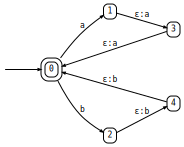

In [13]:
from transduction import FST, EPSILON
def duplicate(V, K):
    "Duplicate (by K > 1) each symbol in the input string, e.g., `abc -> a^K b^K c^K`."
    assert K > 1
    dup = FST()
    dup.add_I(0)
    for b in V:
        dup.add_arc(0, b, b, (0, b))
        for k in range(K-2):
            dup.add_arc((k, b), EPSILON, b, (k+1, b))
        dup.add_arc((K-2, b), EPSILON, b, 0)
    dup.add_F(0)
    return dup.renumber

duplicate({'a', 'b'}, 3)

In [14]:
#fst = examples.duplicate('ab')
#show(fst, 'aaaabbbba')

'aaaabbbba'
'aaaabbbb'
'aaaabbb'
'aaaabb'
'aaaab'
'aaaa'
'aaa'
'aa'
'a'
''


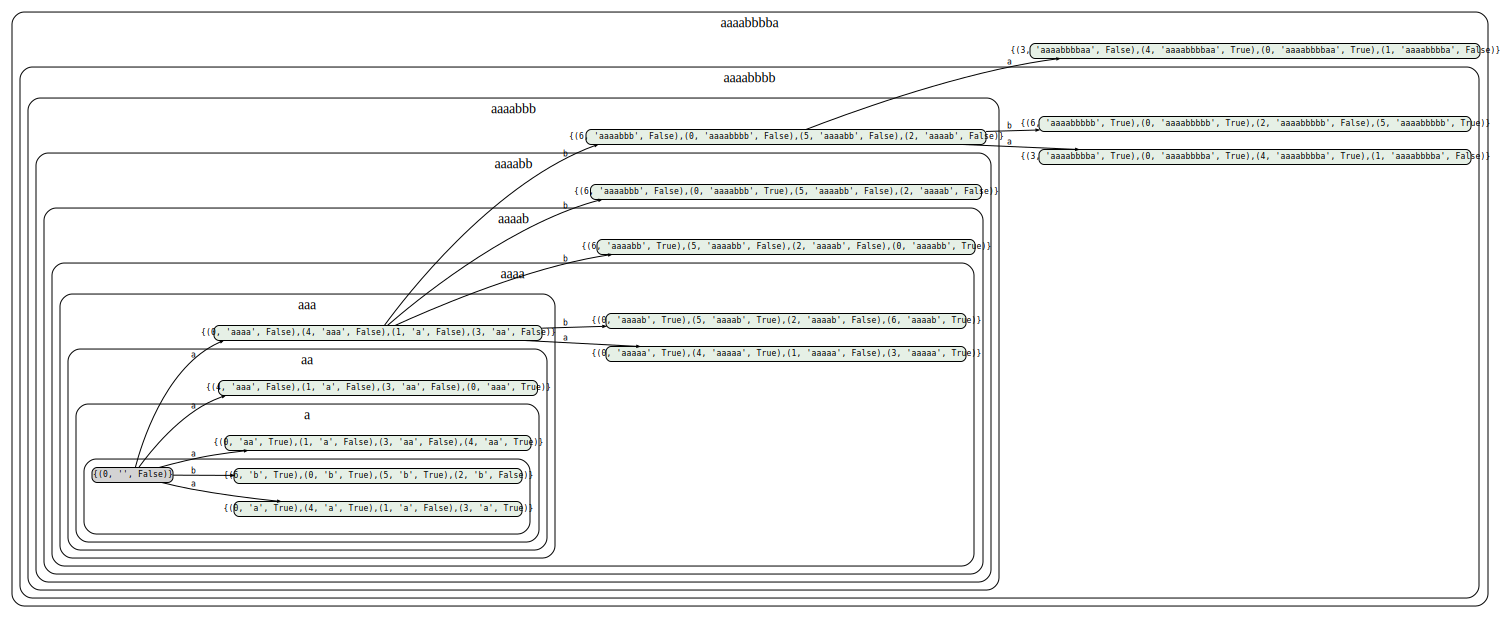

In [15]:
fst = duplicate({'a', 'b'}, 4)
Peekaboo(fst).graphviz('aaaabbbba')

In [16]:
Precover(fst, 'aaaabbbba').show_decomposition()

In [17]:
def poison(V, K):   # k-tuples of doom
    assert K > 1
    dup = FST()
    dup.add_I(0)
    for b in V:
        dup.add_arc(0, b, b, (0, b))
        for k in range(K-2):
            dup.add_arc((k, b), b, b, (k+1, b))        
        dup.add_arc((K-2, b), EPSILON, EPSILON, 0)
    dup.add_F(0)
    return dup.renumber
#p = poison({'a', 'b'}, 3)
#display(p)

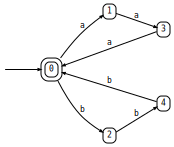

In [18]:
p = examples.triplets_of_doom()
p

In [19]:
list(p.relation(5))

[('', ''), ('aaa', 'aaa'), ('bbb', 'bbb')]

'aaa'
'aa'
'a'
''


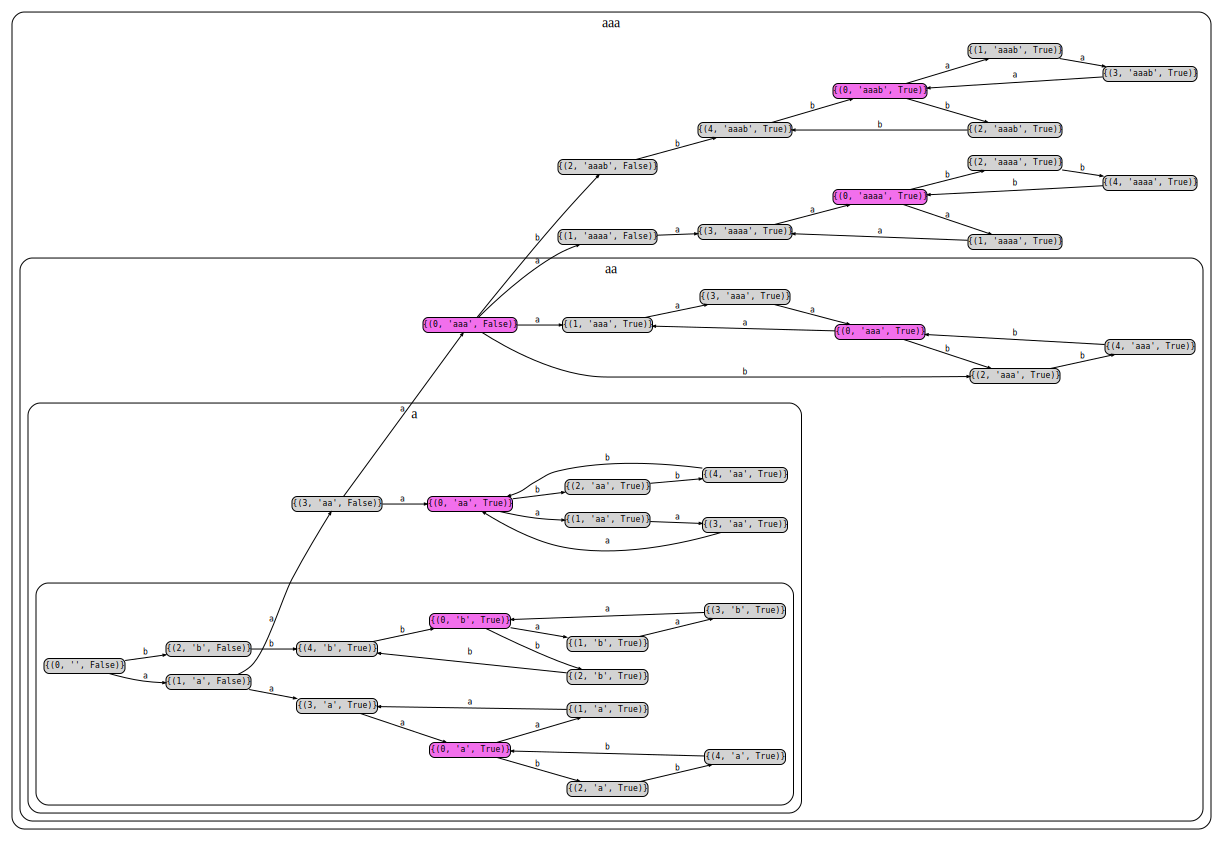

In [20]:
#p = examples.weird_copy()
Peekaboo(p).graphviz('aaa')

In [21]:
# import transduction.peekaboo
# import transduction.peekaboo_recursive
# fst = examples.newspeak2()
# pp = transduction.peekaboo.Peekaboo(p, max_steps=50)
# target = ''
# have = pp(target, return_strings=False)
# want = {y: Precover(p, target + y).decomposition for y in pp.target_alphabet}
# for y in pp.target_alphabet:
#     print(colors.mark(have[y].quotient.equal(want[y].quotient)), colors.mark(have[y].remainder.equal(want[y].remainder)), repr(y))
# #transduction.peekaboo_recursive.assert_equal_decomp_map(have, want)

In [22]:
#import transduction.peekaboo_recursive
#class BufferedRelevance(transduction.peekaboo_recursive.BufferedRelevance):
#    def is_final(self, state): 
#        (i, ys) = state
#        return self.fst.is_final(i) and ys.startswith(self.target)

In [23]:
#dfa = BufferedRelevance(p, 'a').det()
#dfa.materialize(10)

In [24]:
#for x,y in p.relation(5):
#    print([x,y])

In [25]:
#p.renumber.dump()

In [26]:
# from transduction.lazy_recursive import LazyRecursive
# tmp = LazyRecursive(p, max_steps=100)
# tmp('a')

In [27]:
#Precover(p, 'a')

In [28]:
#from transduction.lazy_recursive import LazyRecursive
#tmp = LazyRecursive(p, max_steps=100)
#tmp('ab')

In [29]:
# class BufferedRelevance(transduction.peekaboo_recursive.BufferedRelevance):
#     def is_final(self, state):
#         i, ys = state
#         return self.fst.is_final(i) and ys.startswith(self.target) #and len(ys) == len(self.target) + 1 

In [30]:
# BufferedRelevance(p, 'a').materialize(10)

In [31]:
# from transduction import Precover, EagerNonrecursive
# from transduction.vibes import visualize_automaton
# fst = examples.newspeak2()
# p = Peekaboo(fst)
# target = ''
# have = p(target)
# tmp = EagerNonrecursive(fst)
# want = {y: tmp(target + y) for y in tmp.target_alphabet}
# assert have['b'].quotient.equal(want['b'].quotient)
# #assert_equal_decomp_map(have, want)

In [32]:
#for y in fst.B - {EPSILON}:
#    print(colors.mark(have[y].quotient.equal(want[y].quotient)), colors.mark(have[y].remainder.equal(want[y].remainder)), repr(y))

In [33]:
#have['b'].quotient.min()

In [34]:
#FSA.from_strings(want['b'].quotient).min()

In [35]:
#visualize_automaton(FSA.from_strings(want['b'].quotient).min())

In [36]:
#visualize_automaton(have['b'].quotient.min())

In [37]:
# import transduction.peekaboo
# import transduction.peekaboo_recursive
# fst = examples.newspeak2()
# p = transduction.peekaboo.Peekaboo(fst)
# target = ''
# have = p(target, return_strings=False)
# tmp = EagerNonrecursive(fst)
# want = {y: tmp(target + y) for y in tmp.target_alphabet}
# #for y in fst.B - {EPSILON}:
# #    print(colors.mark(have[y].quotient.equal(want[y].quotient)), colors.mark(have[y].remainder.equal(want[y].remainder)), repr(y))
# transduction.peekaboo_recursive.assert_equal_decomp_map(have, want)

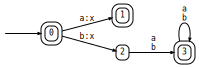

In [38]:
fst = examples.small()
fst

In [39]:
Peekaboo(fst, max_steps=100).check('')

✔ sym: 'x'
✔ sym: 'a'
✔ sym: 'b'


'xab'
'xa'
'x'
''


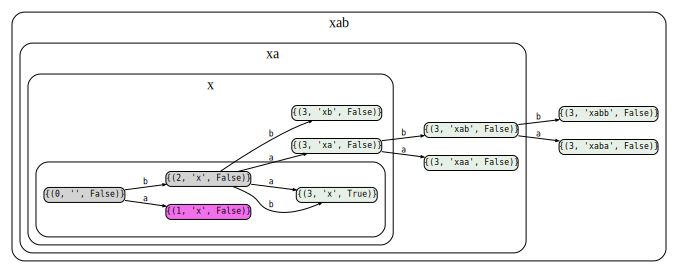

In [40]:
Peekaboo(fst, max_steps=100).graphviz('xab')

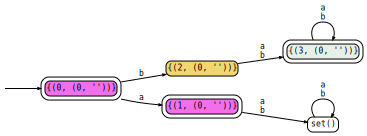

In [41]:
Precover(fst, '')

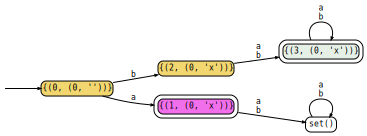

In [42]:
Precover(fst, 'x')

In [43]:
Precover(fst, 'x').show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 1 <!-- start->0 --> start->0 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 b <!-- 1 --> 1 0 <!-- 2->1 --> 2->1 a b","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a"


In [44]:
# def graphviz(fst, target):
#     from graphviz import Digraph
#     from transduction.lazy_nonrecursive import LazyPrecoverNFA

#     # TODO: [2025-12-06 Sat] The funny thing about this picture is that the
#     # plates are technical for the wrong target string.  specifically, they are
#     # the precover of the next-target symbol extension of the target target
#     # context thus, we have in each plate the *union* of the precovers

#     # TODO: use the integerizer here so that nodes are not improperly
#     # equated with thier string representations.
#     from arsenal import Integerizer
#     m = Integerizer()

#     source_alphabet = fst.A - {EPSILON}

#     dups = set()

#     def helper(target, outer):
#         with outer.subgraph(name="cluster") as inner:
#             inner.attr(label=target or 'ε',
#                        style='rounded, filled', color='black', fillcolor='#e0ffe0')

#             if target == '':
#                 old_arcs = set()            
#                 prev_universal = set()
#             else:
#                 prev = helper(target[:-1], inner)
#                 prev_dfa = LazyPrecoverNFA(fst, target[:-1]).det()
#                 old_arcs = {(i,x,j) for i in prev.states for x, j in prev.arcs(i)}
#                 prev_universal = {i for i in prev.states if prev_dfa.accepts_universal(i, source_alphabet)}

#             curr_dfa = LazyPrecoverNFA(fst, target).det()
#             curr = curr_dfa.materialize()
#             new_arcs = {(i,x,j) for i in curr.states for x, j in curr.arcs(i)}
            
#             curr_universal = {i for i in curr.states if curr_dfa.accepts_universal(i, source_alphabet)}
#             curr_remainder = {i for i in curr.states if curr_dfa.is_final(i)} - curr_universal

#             print(repr(target))
            
#             for (i,x,j) in old_arcs - new_arcs:
#                 if i in prev_universal: continue
#                 print(colors.light.red % 'remove:', (i,x,j))
#             for (i,x,j) in new_arcs - old_arcs:
#                 print(colors.light.green % 'added: ', (i,x,j))
#             for (i,x,j) in new_arcs & old_arcs:
#                 if i in prev_universal:
#                     continue
#                 print('keep:  ', (i,x,j))

#             if target:            
#                 for i in prev.states - curr.states:   # removed
#                     pass
#                 for i in curr.states & prev.states:   # kept
#                     if i in curr_universal:
#                         print('===> need to copy old node:', i)
#                     elif i in curr_remainder:
#                         print('===> need to copy old node:', i)                    
#                 for i in curr.states - prev.states:   # addded
#                     pass

#             for i in curr.states:
#                 if i in curr_universal:
#                     inner.node(str(i), fillcolor='red')
#                     continue
#                 elif i in curr_remainder:
#                     inner.node(str(i), fillcolor='magenta')
                
#                 if not i: continue
#                 for x, j in curr.arcs(i):
#                     if not j: continue
#                     if (i,x,j) in dups:
#                         continue
#                     dups.add((i,x,j))
#                     inner.edge(str(i), str(j), label=x)

#             return curr

#     dot = Digraph(
#         graph_attr=dict(rankdir='LR'),
#         node_attr=dict(
#             fontname='Monospace',
#             fontsize='8',
#             height='.05',
#             width='.05',
#             margin="0.055,0.042",
#             shape='box',
#             style='rounded, filled',
#         ),
#         edge_attr=dict(
#             arrowsize='0.3',
#             fontname='Monospace',
#             fontsize='8'
#         ),
#     )

#     with dot.subgraph(name='outer') as outer:
#         helper(target, outer)

#     return dot


In [45]:
# graphviz(fst, 'xabab')

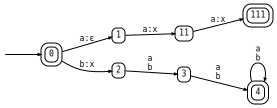

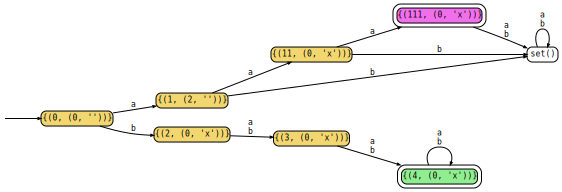

In [66]:
fst = examples.lookahead()

display(fst)
P = Precover(fst, 'x')
display(P)
P.show_decomposition(minimize=False)

'xab'
'xa'
'x'
''


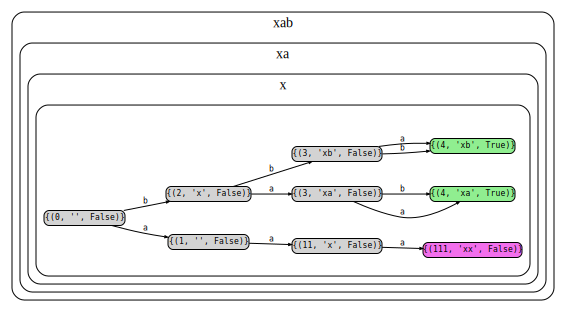

In [67]:
Peekaboo(fst).graphviz('xab')

'xx'
'x'
''


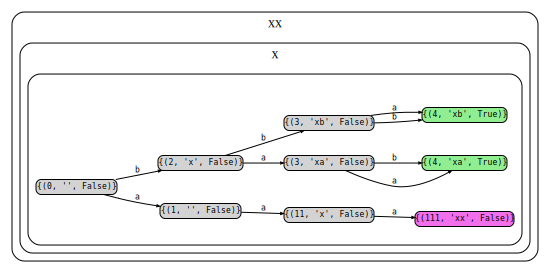

In [68]:
Peekaboo(fst).graphviz('xx')

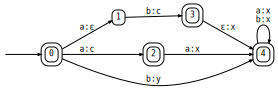

In [49]:
fst = examples.samuel_example()
fst

In [50]:
Target = 'cxx'

In [51]:
from transduction.foo import Analyze, visualization
from graphviz import Digraph

ε


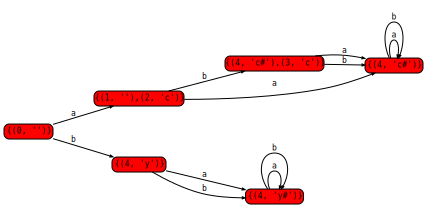

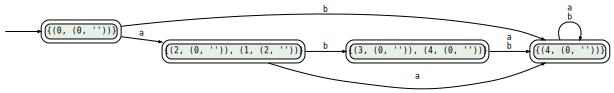

c
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'c#')}
├─ remove: {(4, 'c#'),(3, 'c')}
├─ remove: {(4, 'y#')}
├─ remove: {(4, 'y')}
├─ copy:   {(0, '')}
├─ copy:   {(1, ''),(2, 'c')}
├─ added:  {(4, 'cx')}
├─ added:  {(3, 'c'),(4, 'cx')}
├─ added:  {(4, 'cx#')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ added:  ({(1, ''),(2, 'c')}, 'a', {(4, 'cx')})
├─ added:  ({(1, ''),(2, 'c')}, 'b', {(3, 'c'),(4, 'cx')})
├─ added:  ({(4, 'cx')}, 'a', {(4, 'cx#')})
├─ added:  ({(4, 'cx')}, 'b', {(4, 'cx#')})
├─ added:  ({(3, 'c'),(4, 'cx')}, 'a', {(4, 'cx#')})
├─ added:  ({(3, 'c'),(4, 'cx')}, 'b', {(4, 'cx#')})
├─ added:  ({(4, 'cx#')}, 'a', {(4, 'cx#')})
├─ added:  ({(4, 'cx#')}, 'b', {(4, 'cx#')})


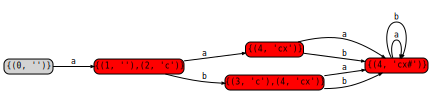

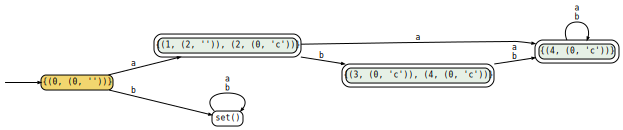

cx
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'cx#')}
├─ copy:   {(0, '')}
├─ copy:   {(4, 'cx')}
├─ copy:   {(3, 'c'),(4, 'cx')}
├─ copy:   {(1, ''),(2, 'c')}
├─ added:  {(4, 'cxx')}
├─ added:  {(4, 'cxx#')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ added:  ({(4, 'cx')}, 'a', {(4, 'cxx')})
├─ added:  ({(4, 'cx')}, 'b', {(4, 'cxx')})
├─ added:  ({(3, 'c'),(4, 'cx')}, 'a', {(4, 'cxx')})
├─ added:  ({(3, 'c'),(4, 'cx')}, 'b', {(4, 'cxx')})
├─ added:  ({(4, 'cxx')}, 'a', {(4, 'cxx#')})
├─ added:  ({(4, 'cxx#')}, 'a', {(4, 'cxx#')})
├─ added:  ({(4, 'cxx')}, 'b', {(4, 'cxx#')})
├─ added:  ({(4, 'cxx#')}, 'b', {(4, 'cxx#')})
├─ copy:   ({(0, '')}, 'a', {(1, ''),(2, 'c')})


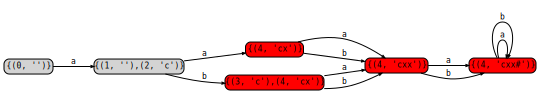

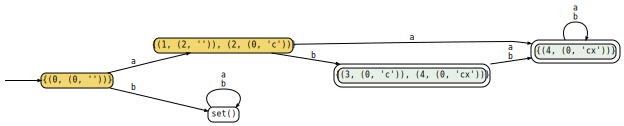

cxx
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'cxx#')}
├─ copy:   {(4, 'cx')}
├─ copy:   {(4, 'cxx')}
├─ copy:   {(3, 'c'),(4, 'cx')}
├─ copy:   {(0, '')}
├─ copy:   {(1, ''),(2, 'c')}
├─ added:  {(4, 'cxxx#')}
├─ added:  {(4, 'cxxx')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ added:  ({(4, 'cxxx#')}, 'a', {(4, 'cxxx#')})
├─ added:  ({(4, 'cxxx#')}, 'b', {(4, 'cxxx#')})
├─ added:  ({(4, 'cxxx')}, 'a', {(4, 'cxxx#')})
├─ added:  ({(4, 'cxx')}, 'a', {(4, 'cxxx')})
├─ added:  ({(4, 'cxxx')}, 'b', {(4, 'cxxx#')})
├─ added:  ({(4, 'cxx')}, 'b', {(4, 'cxxx')})
├─ copy:   ({(1, ''),(2, 'c')}, 'a', {(4, 'cx')})
├─ copy:   ({(0, '')}, 'a', {(1, ''),(2, 'c')})
├─ copy:   ({(1, ''),(2, 'c')}, 'b', {(3, 'c'),(4, 'cx')})


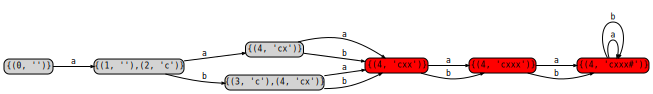

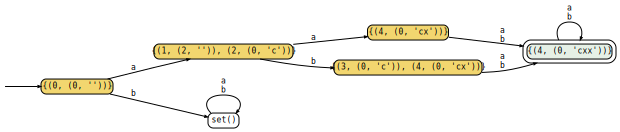

In [52]:
visualization(fst, Target)